
## Adversarial Multimedia Recommendation (AMR)

In [1]:
# Installing the cornac
!pip install cornac

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 31.7 MB/s eta 0:00:00


In [2]:
!sudo add-apt-repository ppa:ubuntu-toolchain-r/test
!sudo apt-get update
!sudo apt-get install --only-upgrade libstdc++6

PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntu-toolchain-r/test/ubuntu/ jammy main'
Description:
Toolchain test builds; see https://wiki.ubuntu.com/ToolChain

More info: https://launchpad.net/~ubuntu-toolchain-r/+archive/ubuntu/test
Adding repository.
Press [ENTER] to continue or Ctrl-c to cancel.
Adding deb entry to /etc/apt/sources.list.d/ubuntu-toolchain-r-ubuntu-test-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntu-toolchain-r-ubuntu-test-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntu-toolchain-r-ubuntu-test.gpg with fingerprint C8EC952E2A0E1FBDC5090F6A2C277A0A352154E5
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [

# Data Ingestion

In [ ]:
# Installing the datasets
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
from datasets import load_dataset
import random

In [ ]:
# Loading the datasets
original_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Amazon_Fashion", trust_remote_code=True)
metadata_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Amazon_Fashion", split="full", trust_remote_code=True)

In [ ]:
print(len(original_dataset['full']), len(metadata_dataset))

2500939 826108


In [ ]:
metadata_dataset[400]

{'main_category': 'AMAZON FASHION',
 'title': "Tropic Bliss Women's Wide Leg Organic Cotton Palazzo Pants in Khaki, XXL",
 'average_rating': 3.9,
 'rating_number': 15,
 'features': ['Drawstring closure', 'Machine Wash'],
 'description': [],
 'price': 'None',
 'images': {'hi_res': ['https://m.media-amazon.com/images/I/618MNMHtbdL._AC_UL1500_.jpg',
   'https://m.media-amazon.com/images/I/71A8TmwL7SL._AC_UL1500_.jpg',
   'https://m.media-amazon.com/images/I/61s4QXQH+3L._AC_UL1500_.jpg',
   'https://m.media-amazon.com/images/I/71Z1UGVTIAL._AC_UL1500_.jpg',
   'https://m.media-amazon.com/images/I/610IJBXky5L._AC_UL1500_.jpg',
   'https://m.media-amazon.com/images/I/71LWu6wyM8L._AC_UL1500_.jpg',
   None],
  'large': ['https://m.media-amazon.com/images/I/319ygz6wyML._AC_.jpg',
   'https://m.media-amazon.com/images/I/31R7LtE49EL._AC_.jpg',
   'https://m.media-amazon.com/images/I/311hhOXu3AL._AC_.jpg',
   'https://m.media-amazon.com/images/I/517w+8dUJJL._AC_.jpg',
   'https://m.media-amazon.com

# Data Cleaning

In [ ]:
# Convert datasets to Pandas DataFrames
original_df = pd.DataFrame(original_dataset['full'])
metadata_df = pd.DataFrame(metadata_dataset)

In [ ]:
# Sample 15,000 parent_asin values
sampled_parent_asin = random.sample(original_df['parent_asin'].unique().tolist(), 25000)

# Filter both DataFrames for sampled parent_asin
original_sampled = original_df[original_df['parent_asin'].isin(sampled_parent_asin)]
metadata_filtered = metadata_df[metadata_df['parent_asin'].isin(sampled_parent_asin)]

# Merge the two datasets on parent_asin
merged_df = pd.merge(original_sampled, metadata_filtered, on='parent_asin', how='inner')

In [ ]:
# Process images
def fetch_image(row):
    hi_res = row['images_y']['hi_res'] if 'hi_res' in row['images_y'] else []
    large = row['images_y']['large'] if 'large' in row['images_y'] else []
    # Use hi_res if available, else large
    for img_list in [hi_res, large]:
        if img_list:
            for img in img_list:
                if img:  # Ensure non-null images
                    return img
    return None

merged_df['image'] = merged_df.apply(fetch_image, axis=1)

# Drop rows where image is null
merged_df = merged_df.dropna(subset=['image'])

# Select the required columns
result_df = merged_df[['parent_asin', 'user_id', 'rating', 'image']]

In [ ]:
result_df.head()

parent_asin                       user_id  rating  \
0  B074DRXHB3  AG2BJOE43JDTA64QMYS6WLUS37WA     4.0   
1  B09DY37VMS  AHV6QCNBJNSGLATP56JAWJ3C4G2A     4.0   
2  B09WL4GSH9  AHV6QCNBJNSGLATP56JAWJ3C4G2A     5.0   
3  B01IX33TWG  AHV6QCNBJNSGLATP56JAWJ3C4G2A     5.0   
4  B012O733N2  AHV6QCNBJNSGLATP56JAWJ3C4G2A     4.0   

                                               image  
0  https://m.media-amazon.com/images/I/81IyJwwxBN...  
1  https://m.media-amazon.com/images/I/01RmK+J4pJ...  
2  https://m.media-amazon.com/images/I/51XjoiUL8V...  
3  https://m.media-amazon.com/images/I/81NuH+v+0H...  
4  https://m.media-amazon.com/images/I/61yuSoLmpW...

In [ ]:
df = result_df.rename(columns={
    'parent_asin': 'item_id'
})

In [ ]:
df.head()

item_id                       user_id  rating  \
0  B074DRXHB3  AG2BJOE43JDTA64QMYS6WLUS37WA     4.0   
1  B09DY37VMS  AHV6QCNBJNSGLATP56JAWJ3C4G2A     4.0   
2  B09WL4GSH9  AHV6QCNBJNSGLATP56JAWJ3C4G2A     5.0   
3  B01IX33TWG  AHV6QCNBJNSGLATP56JAWJ3C4G2A     5.0   
4  B012O733N2  AHV6QCNBJNSGLATP56JAWJ3C4G2A     4.0   

                                               image  
0  https://m.media-amazon.com/images/I/81IyJwwxBN...  
1  https://m.media-amazon.com/images/I/01RmK+J4pJ...  
2  https://m.media-amazon.com/images/I/51XjoiUL8V...  
3  https://m.media-amazon.com/images/I/81NuH+v+0H...  
4  https://m.media-amazon.com/images/I/61yuSoLmpW...

In [ ]:
df.to_csv('Amazon_Fashion_Dataset.csv', index=False)

## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv('/content/Amazon_Fashion_Dataset.csv')

In [2]:
df.head()

item_id                       user_id  rating  \
0  B074DRXHB3  AG2BJOE43JDTA64QMYS6WLUS37WA     4.0   
1  B09DY37VMS  AHV6QCNBJNSGLATP56JAWJ3C4G2A     4.0   
2  B09WL4GSH9  AHV6QCNBJNSGLATP56JAWJ3C4G2A     5.0   
3  B01IX33TWG  AHV6QCNBJNSGLATP56JAWJ3C4G2A     5.0   
4  B012O733N2  AHV6QCNBJNSGLATP56JAWJ3C4G2A     4.0   

                                               image  
0  https://m.media-amazon.com/images/I/81IyJwwxBN...  
1  https://m.media-amazon.com/images/I/01RmK+J4pJ...  
2  https://m.media-amazon.com/images/I/51XjoiUL8V...  
3  https://m.media-amazon.com/images/I/81NuH+v+0H...  
4  https://m.media-amazon.com/images/I/61yuSoLmpW...

In [3]:
df.shape

(73855, 4)

In [4]:
df.isnull().sum()

item_id    0
user_id    0
rating     0
image      0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73855 entries, 0 to 73854
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   item_id  73855 non-null  object 
 1   user_id  73855 non-null  object 
 2   rating   73855 non-null  float64
 3   image    73855 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.3+ MB


#### Display Random Images

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import random

def display_images(df, num_images=1):
    """Displays a specified number of random images from the DataFrame."""

    random_indices = random.sample(range(len(df)), num_images)

    plt.figure(figsize=(15,10))  # Adjust figure size as needed

    for i, index in enumerate(random_indices):
      try:
        image_url = df['image'].iloc[index]
        response = requests.get(image_url, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes

        # Use PIL to open the image and convert it to RGB
        image = Image.open(BytesIO(response.content)).convert('RGB')

        # Convert PIL Image to NumPy array for matplotlib
        image = np.array(image)

        plt.subplot(2, 3, i + 1)  # Adjust subplot grid as needed
        plt.imshow(image)
        plt.axis('off')  # Hide axes
      except (requests.exceptions.RequestException, ValueError, IndexError, OSError) as e:  # Include OSError for image format errors
          print(f"Error displaying image at index {index}: {e}")
          plt.subplot(2,3, i+1)
          plt.text(0.5, 0.5, f"Error loading image", ha='center', va='center')
          plt.axis('off')
          continue

    plt.tight_layout()
    plt.show()

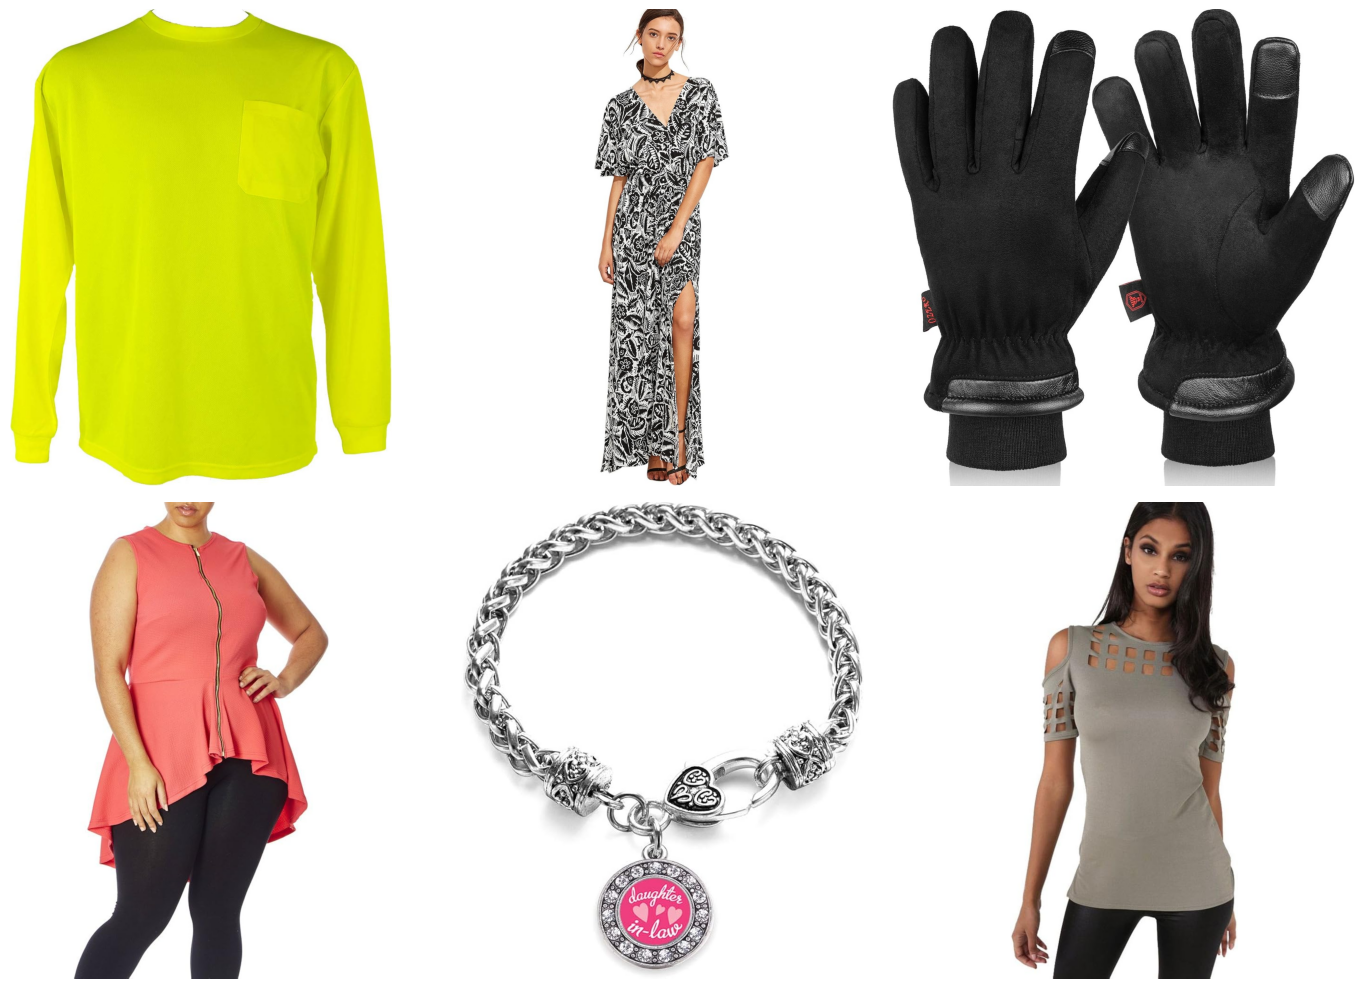

In [7]:
display_images(df, num_images= 6)

## Data Preparation

#### Extracting User_Item Interaction

In [8]:
# User item data
user_item = []
for index, row in df.iterrows():
    user_id = row['user_id']
    item_id = row['item_id']
    rating = row['rating']
    user_item.append((user_id, item_id, rating))

In [9]:
user_item

[('AG2BJOE43JDTA64QMYS6WLUS37WA', 'B074DRXHB3', 4.0),
 ('AHV6QCNBJNSGLATP56JAWJ3C4G2A', 'B09DY37VMS', 4.0),
 ('AHV6QCNBJNSGLATP56JAWJ3C4G2A', 'B09WL4GSH9', 5.0),
 ('AHV6QCNBJNSGLATP56JAWJ3C4G2A', 'B01IX33TWG', 5.0),
 ('AHV6QCNBJNSGLATP56JAWJ3C4G2A', 'B012O733N2', 4.0),
 ('AFJBKPK5W56XWSNPQU2WW66ISWYQ', 'B08T5ZDGSZ', 5.0),
 ('AFJBKPK5W56XWSNPQU2WW66ISWYQ', 'B07Q6CQ2LL', 5.0),
 ('AGTITI6OKWPN2AVELIAJALJFX6NA', 'B07QV4GWWB', 3.0),
 ('AFXF3EGQTQDXMRLDWFU7UBFQZB7Q', 'B08JGK87ZY', 4.0),
 ('AHHFW36BP4VMQWC6V2NTKIXFAA2A', 'B018NBSAV8', 4.0),
 ('AHEJ5LC7BSEADCIZQQQPZPVWOLCA', 'B08GK9QVH3', 5.0),
 ('AEIPJBAN7A55Q5DFFPZSR2UV3OKA', 'B09B3MT7BN', 5.0),
 ('AEIPJBAN7A55Q5DFFPZSR2UV3OKA', 'B09B3MT7BN', 5.0),
 ('AEICZD35OTDYVWA2KPYWN4PDZ2SA', 'B089SY6HWK', 5.0),
 ('AEICZD35OTDYVWA2KPYWN4PDZ2SA', 'B08JYHT3D3', 5.0),
 ('AEICZD35OTDYVWA2KPYWN4PDZ2SA', 'B07Q8FPVF2', 3.0),
 ('AEICZD35OTDYVWA2KPYWN4PDZ2SA', 'B015E5PXYI', 5.0),
 ('AET5VFNIYKIHIPO3ZALZSLXX3KOQ', 'B08CBBP5QX', 3.0),
 ('AFQQQ5LGNSQUEBGDCYBAZZE5T

#### Preparing data for  Image Feature

In [10]:
# Extracting unique combinations
df1 = df.drop_duplicates(subset=['item_id','image'])[['item_id', 'image']]

In [11]:
df1

item_id                                              image
0      B074DRXHB3  https://m.media-amazon.com/images/I/81IyJwwxBN...
1      B09DY37VMS  https://m.media-amazon.com/images/I/01RmK+J4pJ...
2      B09WL4GSH9  https://m.media-amazon.com/images/I/51XjoiUL8V...
3      B01IX33TWG  https://m.media-amazon.com/images/I/81NuH+v+0H...
4      B012O733N2  https://m.media-amazon.com/images/I/61yuSoLmpW...
...           ...                                                ...
73317  B0B8MH83G4  https://m.media-amazon.com/images/I/513cDRROBq...
73319  B09GLSWZ79  https://m.media-amazon.com/images/I/71-e8SMcdO...
73331  B00HUCEQG0  https://m.media-amazon.com/images/I/61dv4boNMI...
73333  B07GJ1RV1H  https://m.media-amazon.com/images/I/61CosT4aoJ...
73360  B00NQN7OK2  https://m.media-amazon.com/images/I/51W6UzTBkh...

[25000 rows x 2 columns]

In [12]:
item_ids = df1['item_id'].tolist()
images = df1['image'].tolist()

In [13]:
print(len(item_ids))
print(len(images))

25000
25000


## Image feature extractor example

In [ ]:
# Use GPU
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: Tesla T4


In [ ]:
# Load model directly
from transformers import AutoImageProcessor, AutoModel
import torch

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = AutoModel.from_pretrained("google/vit-base-patch16-224-in21k")

# Move the model to the desired device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU:", torch.cuda.get_device_name(0))
    model.to(device)  # Move model to GPU
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

CUDA is available. Using GPU: Tesla T4


In [ ]:
from transformers import ViTImageProcessor, ViTModel
from PIL import Image
import requests

In [ ]:
url = 'https://m.media-amazon.com/images/I/41xWMhBlObL._SL1500_.jpg'
image = Image.open(requests.get(url, stream=True).raw)

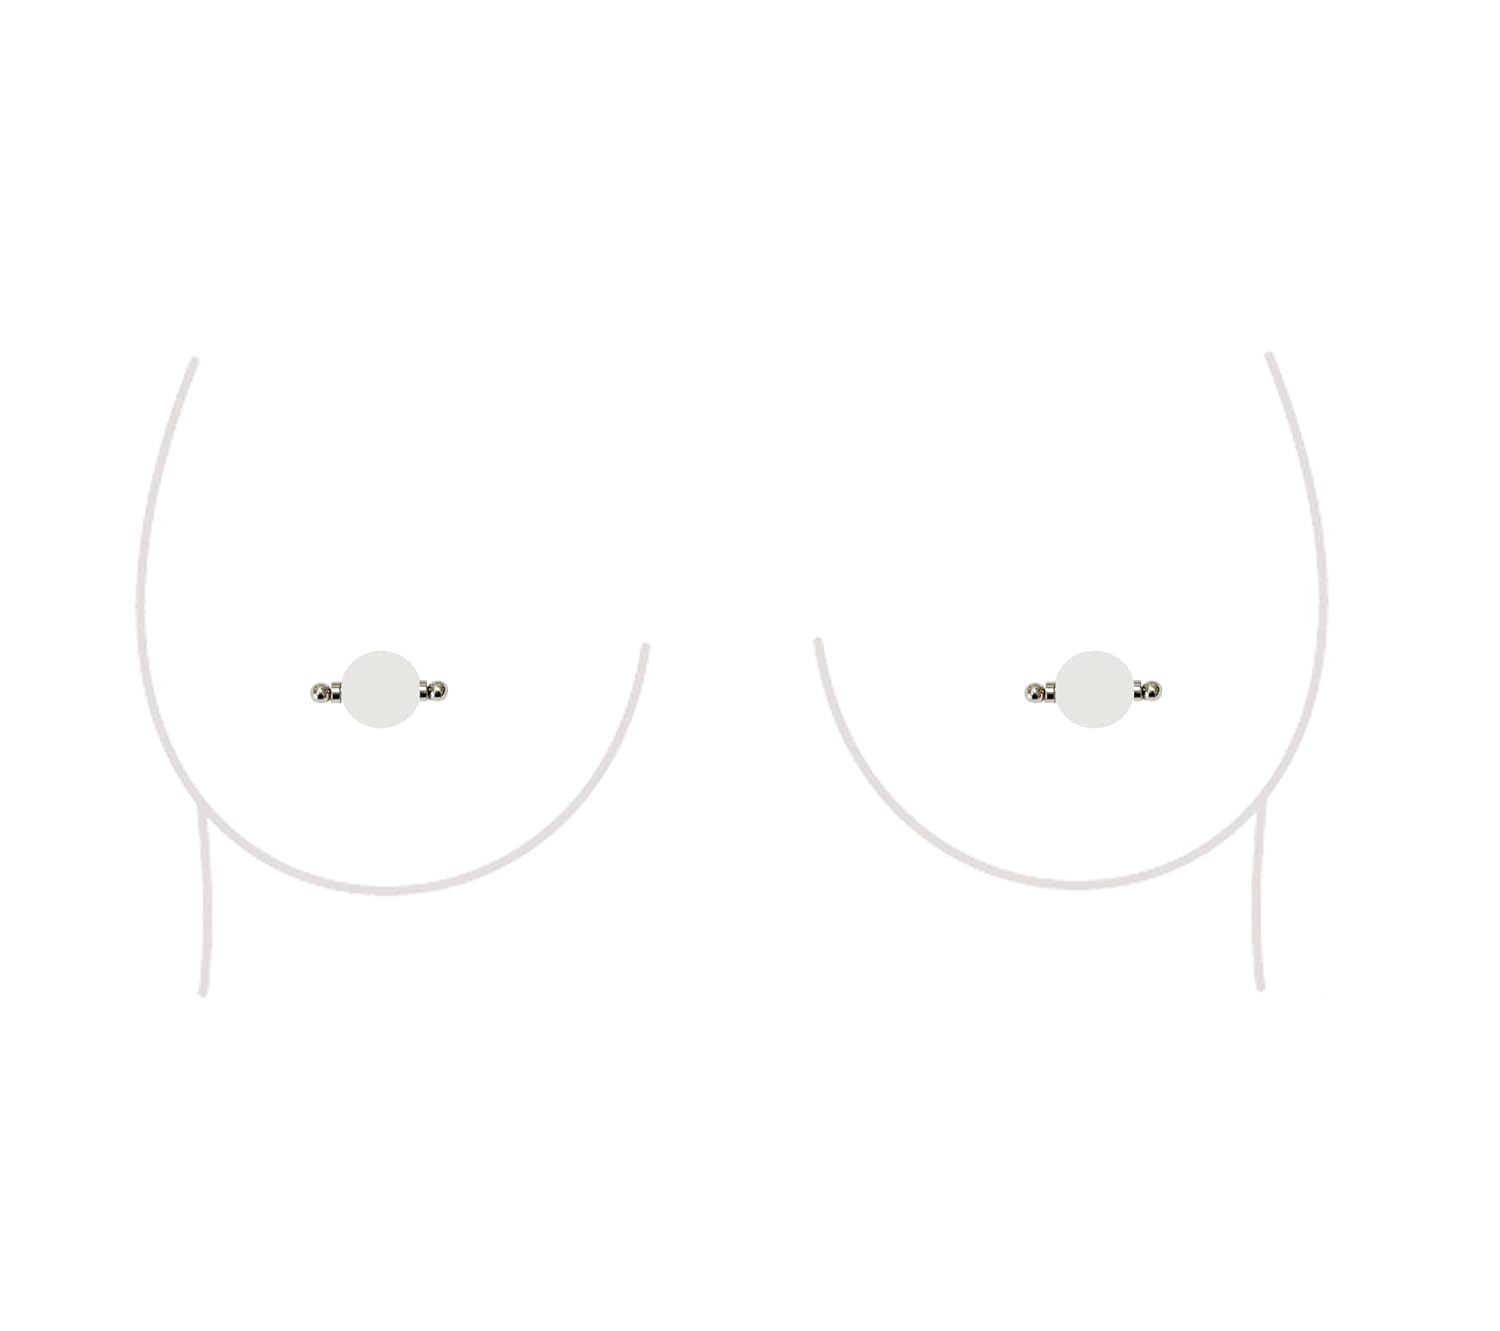

In [ ]:
image

In [ ]:
# Preprocess the image and move to GPU if available
inputs = processor(images=image, return_tensors="pt")
if torch.cuda.is_available(): # Check for GPU availability
    inputs = inputs.to('cuda') # Move inputs to GPU
    model = model.to('cuda')    # Move model to GPU

In [ ]:
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

In [ ]:
# Extracted image feature
last_hidden_states

tensor([[[-0.1765,  0.0268, -0.2364,  ...,  0.0129,  0.0911,  0.1429],
         [-0.2379,  0.3469, -0.1610,  ...,  0.1677,  0.2230, -0.0452],
         [-0.3393,  0.6093, -0.3691,  ...,  0.1780,  0.1669,  0.2289],
         ...,
         [-0.2789,  0.1607, -0.2707,  ...,  0.0235,  0.1869,  0.1717],
         [-0.2326,  0.3925, -0.2846,  ..., -0.0039,  0.1993,  0.1433],
         [-0.1913,  0.3597, -0.1461,  ...,  0.1264,  0.1517, -0.0384]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [ ]:
last_hidden_states.shape

torch.Size([1, 197, 768])

### Feature extractor function

In [ ]:
import requests
import numpy as np
from PIL import Image
import torch
from transformers import ViTFeatureExtractor, ViTModel
from tqdm import tqdm  # For dynamic progress bar

# Load the pre-trained model and feature extractor
processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

def extract_image_features(image_urls):
    """
    Extracts image features using a pre-trained Vision Transformer model.

    Args:
        image_urls: A list of image URLs.

    Returns:
        A NumPy array of shape (num_images, feature_dim) containing the extracted features.
    """
    image_features = []
    success_count = 0  # Counter for successfully extracted features
    total_images = len(image_urls)

    # Initialize the progress bar
    with tqdm(total=total_images, desc="Processing Images", unit="image") as pbar:
        for url in image_urls:
            try:
                # Load the image from URL
                image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

                # Preprocess the image
                inputs = processor(images=image, return_tensors="pt")

                # Move tensors and model to GPU if available
                if torch.cuda.is_available():
                    inputs = inputs.to('cuda')
                    model.to('cuda')

                # Get model outputs
                with torch.no_grad():  # Disable gradient calculation for inference
                    outputs = model(**inputs)

                # Extract features (mean of the last hidden state)
                last_hidden_states = outputs.last_hidden_state
                feature = last_hidden_states.mean(dim=1).cpu().numpy()  # Move back to CPU for NumPy
                image_features.append(feature)
                success_count += 1  # Increment success count

            except Exception as e:
                print(f"\nError processing image {url}: {e}")
                # Append a zero vector in case of error
                image_features.append(np.zeros((1, 768)))  # Assuming 768 is the feature dimension

            # Update the progress bar
            pbar.update(1)
            pbar.set_postfix(Success=success_count, Errors=pbar.n - success_count)

    # Print final summary
    print(f"Total images processed: {total_images}. Features successfully extracted: {success_count}.")
    return np.concatenate(image_features, axis=0)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
image_features_array = extract_image_features(images)

Processing Images:  65%|██████▍   | 16242/25000 [1:48:35<48:41,  3.00image/s, Errors=1, Success=16241]


Error processing image https://m.media-amazon.com/images/I/31DHbGX05ML._AC_.jpg: cannot identify image file <_io.BytesIO object at 0x79f2a0266fc0>


Processing Images:  68%|██████▊   | 16917/25000 [1:53:14<50:58,  2.64image/s, Errors=2, Success=16915]


Error processing image https://m.media-amazon.com/images/I/31DHbGX05ML._AC_.jpg: cannot identify image file <_io.BytesIO object at 0x79f2a010b380>


Processing Images:  72%|███████▏  | 18109/25000 [2:00:57<34:24,  3.34image/s, Errors=3, Success=18106]


Error processing image https://m.media-amazon.com/images/I/71TET-YqVhS._AC_UL1500_.jpg: ('Connection broken: IncompleteRead(30267 bytes read, 165660 more expected)', IncompleteRead(30267 bytes read, 165660 more expected))


Processing Images: 100%|██████████| 25000/25000 [2:46:50<00:00,  2.50image/s, Errors=3, Success=24997]

Total images processed: 25000. Features successfully extracted: 24997.


In [ ]:
import numpy as np
np.save('image_features.npy', image_features_array)

In [ ]:
len(image_features_array)

25000

In [14]:
# Import extracted features
import numpy as np
image_features_array = np.load('/content/image_features (1).npy')

## Making the model

In [15]:
import cornac
from cornac.data import ImageModality
from cornac.eval_methods import RatioSplit

In [16]:
item_image_modality = ImageModality(features=image_features_array, ids=item_ids, normalized=True)

In [17]:
ratio_split = RatioSplit(
    data=user_item,
    test_size=0.1,
    rating_threshold=0.5,
    exclude_unknowns=True,
    verbose=True,
    item_image=item_image_modality,
)

rating_threshold = 0.5
exclude_unknowns = True


/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:335: UserWarning: 645 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.10/dist-packages/cornac/data/dataset.py:335: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


---
Training data:
Number of users = 65191
Number of items = 23445
Number of ratings = 65824
Max rating = 5.0
Min rating = 1.0
Global mean = 4.0
---
Test data:
Number of users = 65191
Number of items = 23445
Number of ratings = 214
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 65191
Total items = 23445


In [18]:
# Instantiate AMR
amr = cornac.models.AMR(
    k=32,                  # The dimension of the gamma latent factors.
    k2=32,                 # The dimension of the theta latent factors.
    n_epochs=10,           # Maximum number of epochs for SGD
    batch_size=1024,       # The batch size for SGD.
    learning_rate=0.001,   # The learning rate for SGD.
    lambda_w=1,            # The regularization hyper-parameter for latent factor weights.
    lambda_b=0.01,         # The regularization hyper-parameter for biases.
    lambda_e=0.01,          # The regularization hyper-parameter for embedding matrix E and beta prime vector.
    use_gpu=True,          # Whether or not to use GPU to speed up training.
)

In [19]:
# Instantiate evaluation measures
rec_50 = cornac.metrics.Recall(k=50)
precis_50 = cornac.metrics.Precision(k=50)

In [20]:
# Put everything together into an experiment and run it
cornac.Experiment(eval_method=ratio_split, models=[amr], metrics=[rec_50,precis_50]).run()


[AMR] Training started!


Epoch 1/10:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/65 [00:00<?, ?it/s]

Optimization finished!

[AMR] Evaluation started!


Ranking:   0%|          | 0/211 [00:00<?, ?it/s]


TEST:
...
    | Precision@50 | Recall@50 | Train (s) | Test (s)
--- + ------------ + --------- + --------- + --------
AMR |       0.0016 |    0.0806 |  265.4027 |   0.6550



## Making Recommendation

In [41]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import requests
from PIL import Image
from io import BytesIO

def show_recommended_images(rec_item, df1):
    """Displays images for recommended items in a grid layout with clickable links using Plotly.

    Args:
        rec_item: A list of item IDs.
        df1: DataFrame containing item IDs and image paths.
    """
    images = []
    titles = []
    links = []

    for item_id in rec_item:
        try:
            # Fetch image path from DataFrame
            image_path = df1.loc[df1['item_id'] == item_id, 'image'].iloc[0]

            # Fetch the image from the URL
            response = requests.get(image_path, stream=True)
            response.raise_for_status()
            image = Image.open(BytesIO(response.content))

            # Append image and title with link
            images.append(px.imshow(image).data[0])
            product_link = f"https://www.amazon.com/dp/{item_id}"
            titles.append(f"<a href='{product_link}' target='_blank'> Click here for Amazon </a>")
        except (requests.exceptions.RequestException, ValueError, IOError, IndexError) as e:
            print(f"Error displaying image for item {item_id}: {e}")

    # Create subplots
    num_items = len(rec_item)
    num_columns = 3
    num_rows = -(-num_items // num_columns)  # Ceiling division

    fig = make_subplots(rows=num_rows, cols=num_columns, subplot_titles=titles)

    for i, image_data in enumerate(images):
        row = i // num_columns + 1
        col = i % num_columns + 1
        fig.add_trace(image_data, row=row, col=col)

    # Update layout to increase subplot size and hide axes
    fig.update_layout(
        height=num_rows * 400,  # Increase height of each subplot
        width=1200,            # Increase total width of the plot
        title_text=f"Recommended Items for user {user}" ,
        showlegend=False
    )
    fig.update_xaxes(visible=False)  # Hide x-axis
    fig.update_yaxes(visible=False)  # Hide y-axis

    fig.show()

In [43]:
user_item

[('AG2BJOE43JDTA64QMYS6WLUS37WA', 'B074DRXHB3', 4.0),
 ('AHV6QCNBJNSGLATP56JAWJ3C4G2A', 'B09DY37VMS', 4.0),
 ('AHV6QCNBJNSGLATP56JAWJ3C4G2A', 'B09WL4GSH9', 5.0),
 ('AHV6QCNBJNSGLATP56JAWJ3C4G2A', 'B01IX33TWG', 5.0),
 ('AHV6QCNBJNSGLATP56JAWJ3C4G2A', 'B012O733N2', 4.0),
 ('AFJBKPK5W56XWSNPQU2WW66ISWYQ', 'B08T5ZDGSZ', 5.0),
 ('AFJBKPK5W56XWSNPQU2WW66ISWYQ', 'B07Q6CQ2LL', 5.0),
 ('AGTITI6OKWPN2AVELIAJALJFX6NA', 'B07QV4GWWB', 3.0),
 ('AFXF3EGQTQDXMRLDWFU7UBFQZB7Q', 'B08JGK87ZY', 4.0),
 ('AHHFW36BP4VMQWC6V2NTKIXFAA2A', 'B018NBSAV8', 4.0),
 ('AHEJ5LC7BSEADCIZQQQPZPVWOLCA', 'B08GK9QVH3', 5.0),
 ('AEIPJBAN7A55Q5DFFPZSR2UV3OKA', 'B09B3MT7BN', 5.0),
 ('AEIPJBAN7A55Q5DFFPZSR2UV3OKA', 'B09B3MT7BN', 5.0),
 ('AEICZD35OTDYVWA2KPYWN4PDZ2SA', 'B089SY6HWK', 5.0),
 ('AEICZD35OTDYVWA2KPYWN4PDZ2SA', 'B08JYHT3D3', 5.0),
 ('AEICZD35OTDYVWA2KPYWN4PDZ2SA', 'B07Q8FPVF2', 3.0),
 ('AEICZD35OTDYVWA2KPYWN4PDZ2SA', 'B015E5PXYI', 5.0),
 ('AET5VFNIYKIHIPO3ZALZSLXX3KOQ', 'B08CBBP5QX', 3.0),
 ('AFQQQ5LGNSQUEBGDCYBAZZE5T

In [48]:
# Recommand For a user
user = 'AFGDRVPCP742YM5MMLFIKZCGNNRQ'
rec_item = amr.recommend(user,k=6)

In [49]:
show_recommended_images(rec_item, df1)